Keypoints image 1: 10730, image 2: 16017


(np.float64(-0.5), np.float64(1599.5), np.float64(639.5), np.float64(-0.5))

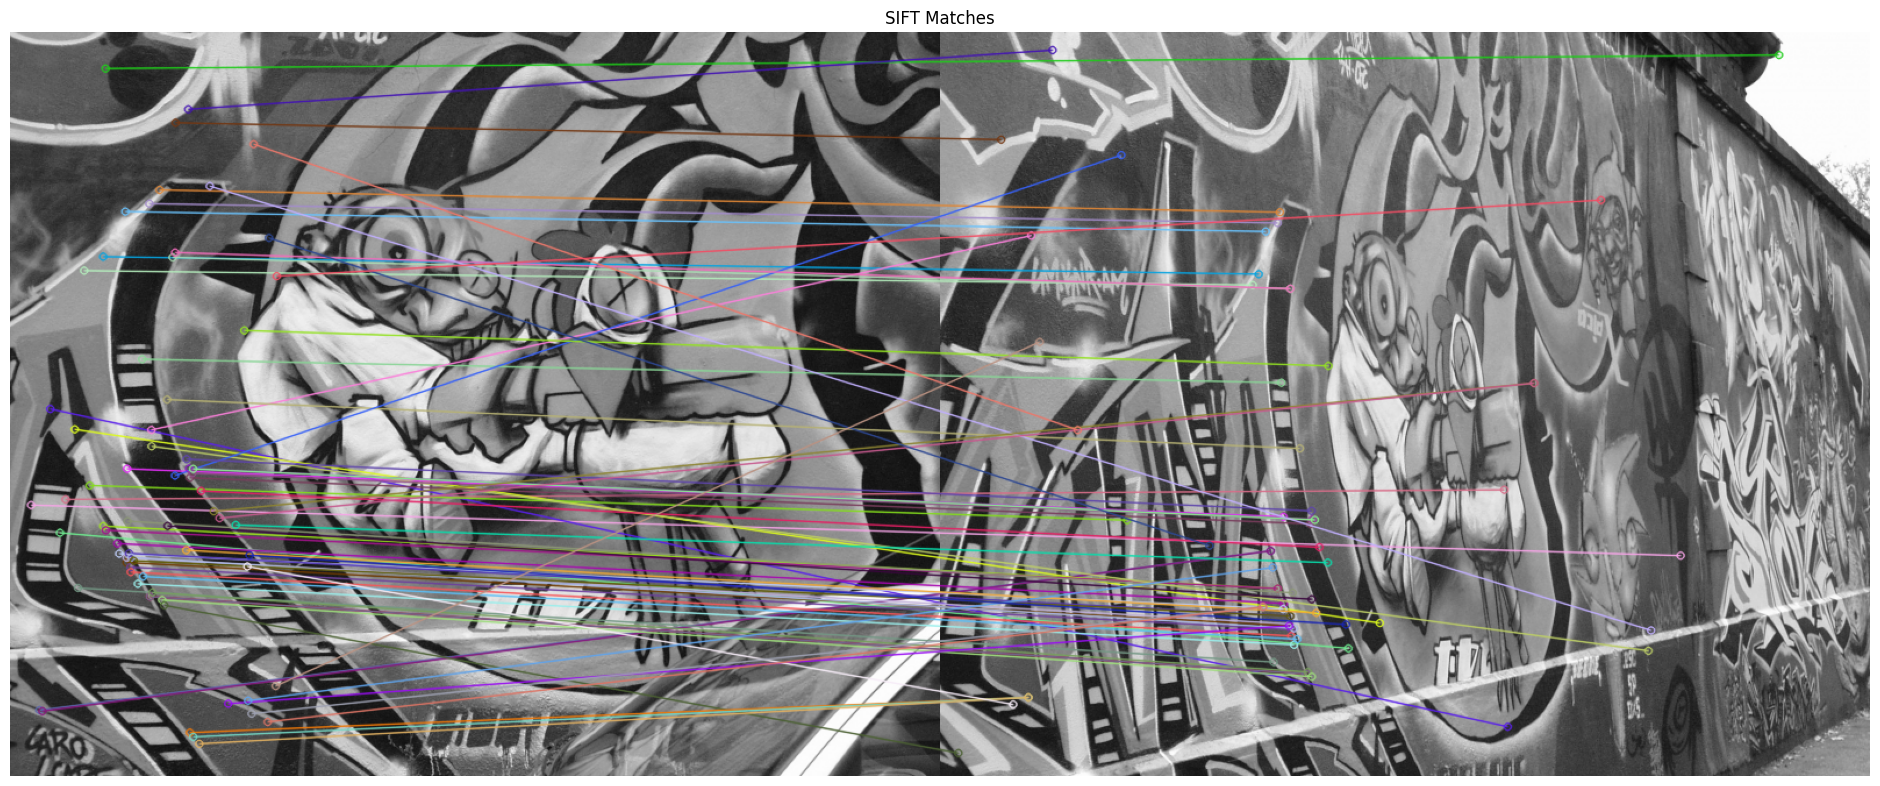

In [4]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load images
img1 = cv.imread('graf/graf/img1.ppm', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('graf/graf/img5.ppm', cv.IMREAD_GRAYSCALE)

def match_images(img1, img2, nOclayers=5, contrastThreshold=0.04, edgeThreshold=10, sigma=1.6, no_good_matches=70):

    sift = cv.SIFT_create(
        nOctaveLayers=nOclayers,         # 4–5 is plenty for large scale changes
        contrastThreshold=contrastThreshold,  # lower to detect more keypoints in low contrast
        edgeThreshold=edgeThreshold,        # good balance — filters unstable edge responses
        sigma=sigma               # slightly higher = more scale & rotation invariance
    )

    # --- 2. Detect keypoints and descriptors ---
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    print(f"Keypoints image 1: {len(kp1)}, image 2: {len(kp2)}")

    # --- 3. KNN matching ---
    bf = cv.BFMatcher(cv.NORM_L2)
    knn_matches = bf.knnMatch(des1, des2, k=2)

    # --- 4. Lowe's ratio test ---
    good_matches = []
    for m, n in knn_matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    matches1 = []
    matches2 = []
    for i, m in enumerate(good_matches[:no_good_matches]):
        matches1.append(kp1[m.queryIdx].pt)
        matches2.append(kp2[m.trainIdx].pt)


    # Draw the top 70 matches
    matched_img = cv.drawMatches(img1, kp1, img2, kp2, good_matches[:no_good_matches], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return matched_img, matches1, matches2

matched_img, matches1, matches2 = match_images(img1, img2, nOclayers=10, contrastThreshold=0.04, edgeThreshold=10, sigma=0.7, no_good_matches=70)
# Display the matched image
fig, ax = plt.subplots(1, 1, figsize=(24, 12))
ax.imshow(cv.cvtColor(matched_img, cv.COLOR_BGR2RGB))
ax.set_title('SIFT Matches')
ax.axis('off')

In [5]:
def compute_error_homography(H, X, Y):
    point_homogeneous = np.array([X[0], X[1], 1]).reshape(3, 1)
    projected_point = H @ point_homogeneous
    projected_point /= projected_point[2]
    error = np.sqrt((projected_point[0] - Y[0])**2 + (projected_point[1] - Y[1])**2)
    return error

def RANSAC_SIFT(X, Y, N, threshold, inl):
    for i in range(N): #number of iterations decided from the equation with 0.99 probability
        count = 0
        inliers = []
        idx = np.random.choice(len(X), size=4, replace=False)
        src_pts = np.float32([X[idx[0]], X[idx[1]], X[idx[2]], X[idx[3]]]).reshape(-1, 1, 2)
        dst_pts = np.float32([Y[idx[0]], Y[idx[1]], Y[idx[2]], Y[idx[3]]]).reshape(-1, 1, 2)
        H = cv.getPerspectiveTransform(src_pts, dst_pts)
        for id in range(len(X)):
            error = compute_error_homography(H, X[id], Y[id])
            if error < threshold: #threshold decided from the 1.96*sigma in line points
                inliers.append(id)
                count += 1
        if count >= inl: #if more than 30 points are inlier, we can stop
            best_homography = H
            return best_homography, count, inliers, idx
        print(i, count)

In [11]:
def draw_homography_border(img1, img2, H, color=(0, 0, 255), thickness=3):
    """
    Draw the projected border of img1 on img2 using the homography H.
    """
    h, w = img1.shape[:2]

    # Define corners of img1
    corners = np.float32([[0, 0],
                          [w, 0],
                          [w, h],
                          [0, h]]).reshape(-1, 1, 2)

    # Project corners to img2
    projected_corners = cv.perspectiveTransform(corners, H)

    # Draw polygon on a copy of img2
    img2_with_border = img2.copy()
    cv.polylines(img2_with_border, [np.int32(projected_corners)],
                 isClosed=True, color=color, thickness=thickness)

    # Show result
    plt.figure(figsize=(12, 8))
    if len(img2.shape) == 2:  # grayscale
        plt.imshow(img2_with_border, cmap='gray')
    else:
        plt.imshow(cv.cvtColor(img2_with_border, cv.COLOR_BGR2RGB))
    plt.title('Projected Homography Border')
    plt.axis('off')
    plt.show()

    return img2_with_border

In [12]:
# Load images
img1 = cv.imread('graf/graf/img1.ppm', cv.IMREAD_COLOR)
img2 = cv.imread('graf/graf/img5.ppm', cv.IMREAD_COLOR)

matched_img, matches1, matches2 = match_images(img1, img2, nOclayers=10, contrastThreshold=0.03, edgeThreshold=11, sigma=0.68, no_good_matches=70)

figure, ax = plt.subplots(1, 1, figsize=(24, 12))
ax.imshow(cv.cvtColor(matched_img, cv.COLOR_BGR2RGB))
ax.set_title('SIFT Matches')
ax.axis('off')

Keypoints image 1: 12801, image 2: 19411


(np.float64(-0.5), np.float64(1599.5), np.float64(639.5), np.float64(-0.5))

0 4
1 4
2 6
3 4
4 8
5 5
6 8
7 6
8 4
9 4
10 5
11 7
12 8
13 7
14 6
15 4
16 6
17 7
18 5
19 12
20 6
21 4
22 4
23 4
24 4
25 6
26 4
27 5
28 4
29 5
30 11
31 4
32 10
33 4
34 4
35 4
36 6
37 5
38 4
39 6
40 4
41 11
42 6
43 5
44 6
45 6
46 6
47 6
48 5
49 6
50 5
51 4
52 9
53 4
54 7
55 8
56 5
57 4
58 7
59 4
60 4
61 5
62 4
63 4
64 4
65 4
66 4
67 6
68 4
69 4
70 2
71 4
72 7
73 4
74 5
75 4
76 4
77 5
78 4
79 5
80 4
81 7
82 6
83 4
84 11
85 5
86 4
87 4
88 6
89 6
90 4
91 4
92 7
93 7
94 5
95 4
96 4
97 6
98 5
99 4
100 5
101 5
102 4
103 6
104 4
105 19
106 4
107 6
108 4
109 5
110 5
111 8
112 4
113 4
114 5
115 10
116 5
117 4
118 4
119 5
120 9
121 4
122 4
123 4
124 5
125 5
126 2
127 5
128 5
129 5
130 4
131 4
132 2
133 5
134 5
135 5
136 3
137 4
138 9
139 5
140 5
141 6
142 4
143 10
144 4
145 4
146 7
147 5
148 4
149 4
150 4
151 4
152 5
153 5
154 5
155 4
156 4
157 5
158 6
159 6
160 5
161 13
162 6
163 10
164 4
165 4
166 5
167 4
168 4
169 4
170 4
171 6
172 4
173 4
174 4
175 6
176 4
177 5
178 4
179 12
180 4
181 4
182 6
1

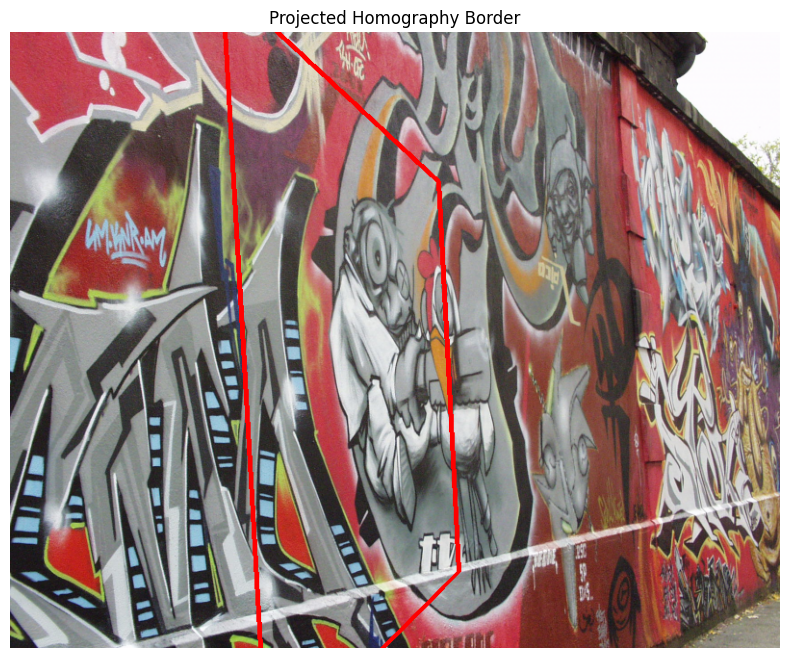

In [13]:
homography, count, inliers, idx = RANSAC_SIFT(matches1, matches2, 10000, threshold=4.0, inl=25)

print(f"Best homography {homography} found with {count} inliers")

result_img = draw_homography_border(img1, img2, homography)

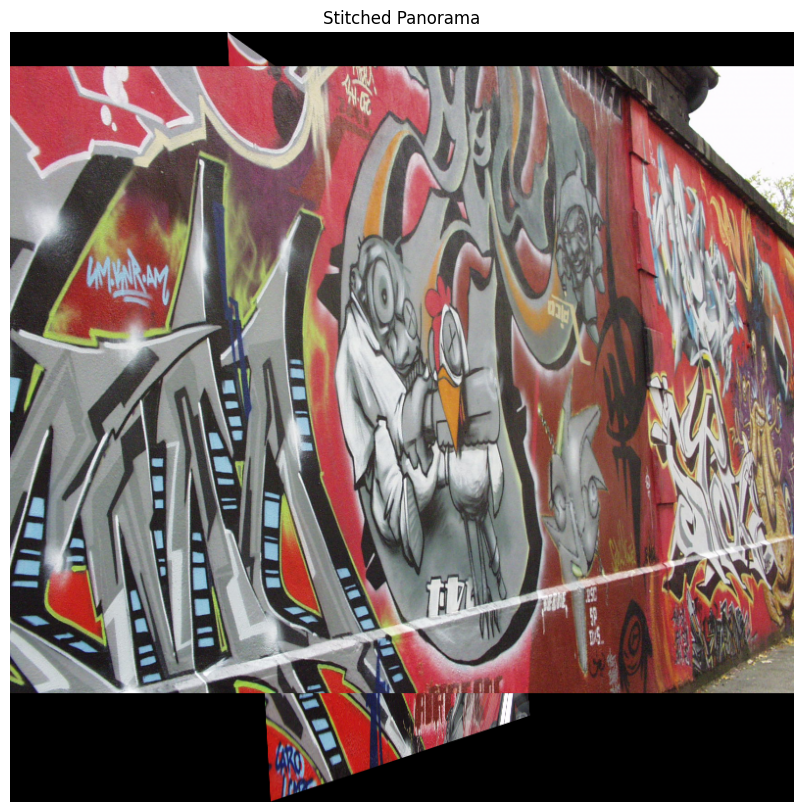

In [10]:
h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]

pts_img1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
pts_img1_transformed = cv.perspectiveTransform(pts_img1, homography)
pts_img2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)

pts = np.concatenate((pts_img1_transformed, pts_img2), axis=0)
[x_min, y_min] = np.int32(pts.min(axis=0).ravel() - 0.5)
[x_max, y_max] = np.int32(pts.max(axis=0).ravel() + 0.5)
translation_dist = [-x_min, -y_min]

H_translation = np.array([[1, 0, translation_dist[0]],
                          [0, 1, translation_dist[1]],
                          [0, 0, 1]])

result = cv.warpPerspective(img1, H_translation @ homography, (x_max - x_min, y_max - y_min))
result[translation_dist[1]:h2+translation_dist[1],
       translation_dist[0]:w2+translation_dist[0]] = img2


plt.figure(figsize=(20,10))
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Stitched Panorama')
plt.show()